# DX702 — Coding Homework Week 3

In [1]:
# === Setup ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper: nice display options
pd.set_option('display.max_colwidth', 120)
pd.set_option('display.precision', 4)

print('✅ Libraries imported.')

✅ Libraries imported.


=== RDD results (event at time = 50) ===

[value1]
  post (level jump)     = -4.3628  (SE 0.7590, t -5.75)
  t_post (slope change) = 0.1053  (SE 0.0132, t 7.95)

[value2]
  post (level jump)     = -1.1449  (SE 0.8243, t -1.39)
  t_post (slope change) = 0.0369  (SE 0.0144, t 2.57)

[value3]
  post (level jump)     = -0.7422  (SE 0.7531, t -0.99)
  t_post (slope change) = 0.0507  (SE 0.0131, t 3.86)


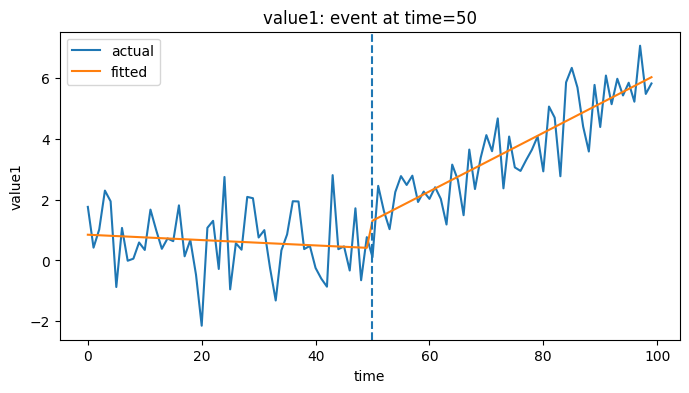

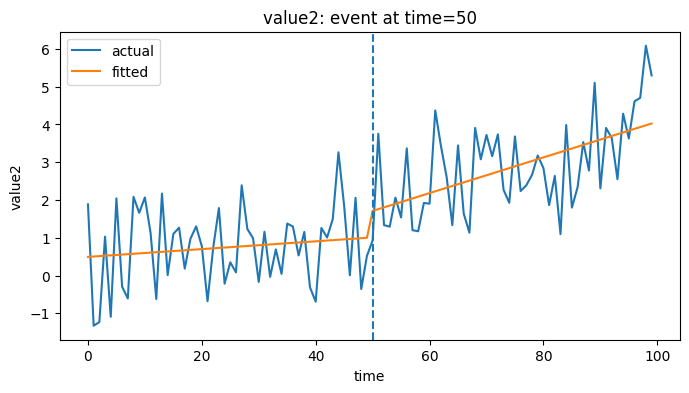

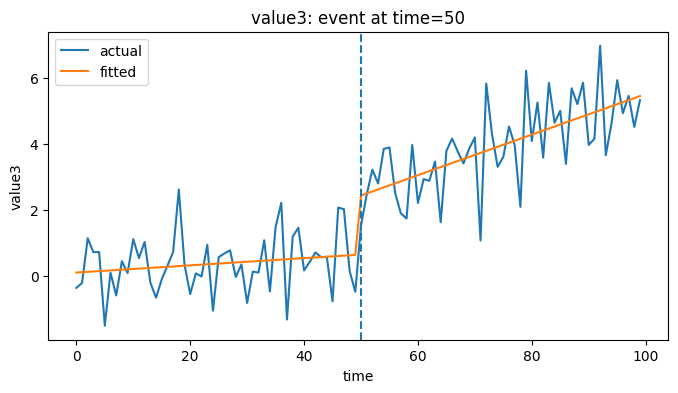

In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load
df = pd.read_csv("homework_3.1.csv")

EVENT_TIME = 50

# Build design: y ~ 1 + t + post + t_post
df = df.copy()
df["t"] = df["time"].astype(float)
df["post"] = (df["time"] >= EVENT_TIME).astype(int)
df["t_post"] = df["t"] * df["post"]

series = ["value1", "value2", "value3"]

def fit_rdd(y):
    X = np.column_stack([
        np.ones(len(df)),         # intercept
        df["t"].values,           # time trend
        df["post"].values,        # level jump at event
        df["t_post"].values       # slope change after event
    ])
    y = df[y].values.astype(float)
    XtX = X.T @ X
    beta = np.linalg.pinv(XtX) @ (X.T @ y)
    y_hat = X @ beta

    # standard errors (non-robust OLS)
    resid = y - y_hat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)
    var_beta = sigma2 * np.linalg.pinv(XtX)
    se = np.sqrt(np.diag(var_beta))
    tstats = beta / se
    return beta, se, tstats, y_hat

results = {}
print("=== RDD results (event at time = 50) ===")
for col in series:
    beta, se, tstats, yhat = fit_rdd(col)
    results[col] = {"beta": beta, "se": se, "t": tstats, "yhat": yhat}
    print(f"\n[{col}]")
    print(f"  post (level jump)     = {beta[2]:.4f}  (SE {se[2]:.4f}, t {tstats[2]:.2f})")
    print(f"  t_post (slope change) = {beta[3]:.4f}  (SE {se[3]:.4f}, t {tstats[3]:.2f})")

# Plots
for col in series:
    plt.figure(figsize=(8,4))
    plt.plot(df["time"], df[col], label="actual")
    plt.plot(df["time"], results[col]["yhat"], label="fitted")
    plt.axvline(EVENT_TIME, linestyle="--")
    plt.title(f"{col}: event at time={EVENT_TIME}")
    plt.xlabel("time"); plt.ylabel(col); plt.legend()
    plt.show()

In [19]:
import numpy as np
import pandas as pd

def did_regression(y, treat, post):
    X = np.column_stack([
        np.ones(len(y)),        # intercept
        treat,
        post,
        treat * post            # interaction (DiD effect)
    ])
    # OLS closed-form
    XtX = X.T @ X
    XtX_inv = np.linalg.pinv(XtX)
    beta = XtX_inv @ (X.T @ y)
    y_hat = X @ beta

    # SE / t-stats (non-robust)
    resid = y - y_hat
    n, k = X.shape
    sigma2 = (resid @ resid) / (n - k)
    var_beta = sigma2 * XtX_inv
    se = np.sqrt(np.diag(var_beta))
    t = beta / se
    return beta, se, t

# Group 1 (homework_3.2.a.csv)
dfa = pd.read_csv("homework_3.2.a.csv")
beta_a, se_a, t_a = did_regression(
    y=dfa["outcome1"].values.astype(float),
    treat=dfa["group1"].values.astype(float),
    post=dfa["time1"].values.astype(float)
)

# Group 2 (homework_3.2.b.csv)
dfb = pd.read_csv("homework_3.2.b.csv")
beta_b, se_b, t_b = did_regression(
    y=dfb["outcome2"].values.astype(float),
    treat=dfb["group2"].values.astype(float),
    post=dfb["time2"].values.astype(float)
)

def extract_effect(beta, se, t):
    # index 3 corresponds to treat:post
    return float(beta[3]), float(se[3]), float(t[3])

eff_a, seA, tA = extract_effect(beta_a, se_a, t_a)
eff_b, seB, tB = extract_effect(beta_b, se_b, t_b)

print("=== DiD results ===")
print(f"Group 1 (file a): effect={eff_a:.6f}, SE={seA:.6f}, t={tA:.3f}")
print(f"Group 2 (file b): effect={eff_b:.6f}, SE={seB:.6f}, t={tB:.3f}")

=== DiD results ===
Group 1 (file a): effect=0.685847, SE=0.062522, t=10.970
Group 2 (file b): effect=1.349859, SE=0.147047, t=9.180
